<img src="https://www.python.org/static/img/python-logo.png">

# Welcome to my lessons

---

**Bo Zhang** (NAOC, <mailto:bozhang@nao.cas.cn>) will have a few lessons on python.

- These are **very useful knowledge, skills and code styles** when you use `python` to process astronomical data.
- All materials can be found on [**my github page**](https://github.com/hypergravity/cham_teaches_python).
- **jupyter notebook** (formerly named **ipython notebook**) is recommeded to use

---
These lectures are organized as below:
1. install python
2. basic syntax
3. numerical computing
4. scientific computing
5. plotting
6. astronomical data processing
7. high performance computing
8. version control


# flowchart
0. test your code **BEFORE** you do **ANY** optimization!
1. find the bottleneck of your code (ps: learn to use profiler to find the bottleneck)
2. use tricks, experience to optimize code
3. use as many computing resources as possible
    1. parallel computing in multi-CPU/core computer (`multiprocessing`, ...)
                
    2. run code on multi-node computer cluster (`PBS`, ...)

# some simple principles for optimization
    1. memory vs. speed
    2. vectorization
    3. type check
    4. parallel    

# recommended packages
    1. numexpr
    2. Cython
    - parallel
        1. multiprocessing (standard library)
        2. ipcluster/ipyparallel (support PBS)


# further reading
1. Parallel Programming with Python
2. Python High performance Programming
3. Learning Cython Programming


# Parallel computing
- **threads**: shared memory, involves locks
- **processes**: isolated memory for each process, inter-process communication is less efficient
    - the easiest way to do parallel computing: **embarassingly parallel** (no inter-process communication), which is the case we met most often

# Monte Carlo approximation for $\pi$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


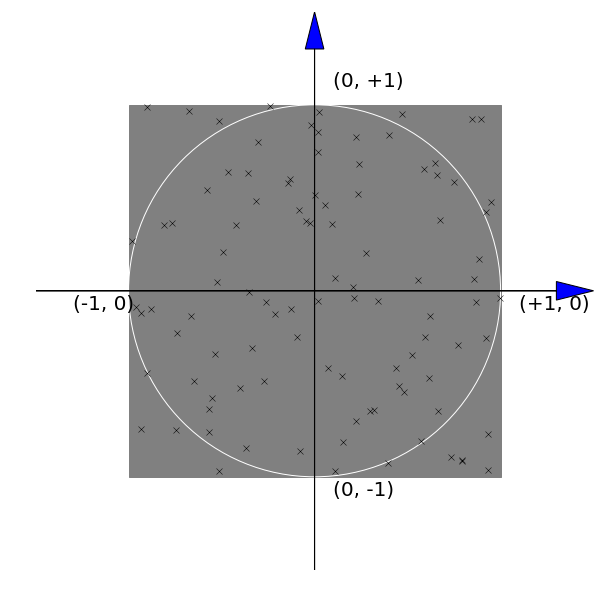

In [2]:
# with plt.xkcd():
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
circle = plt.Circle((0.,0.), 1., color='w', fill=False)
rect = plt.Rectangle((-1,-1), 2, 2, color='gray')
plt.gca().add_artist(rect)
plt.gca().add_artist(circle)
plt.arrow(-2., 0., 3.3, 0., head_width=0.1, head_length=0.2)
plt.arrow(0., -2., 0., 3.3, head_width=0.1, head_length=0.2)
randx = np.random.uniform(-1, 1, (100,))
randy = np.random.uniform(-1, 1, (100,))
plot(randx, randy, 'kx')
plt.gca().axis('off')

plt.text(-1.3, -0.1, '(-1, 0)', fontsize=20)
plt.text( 1.1, -0.1, '(+1, 0)', fontsize=20)
plt.text( 0.1,  1.1, '(0, +1)', fontsize=20)
plt.text( 0.1, -1.1, '(0, -1)', fontsize=20);

In [3]:
%%time

import random
samples = 1E5
hits = 0

for i in range(int(samples)):
    x = random.uniform(-1.0, 1.0)
    y = random.uniform(-1.0, 1.0)
    
    if x**2 + y**2 <= 1.0:
        hits += 1
    
pi = 4.0*hits/samples
print pi


3.13624
CPU times: user 103 ms, sys: 2.29 ms, total: 105 ms
Wall time: 104 ms


## DO NOTICE , this is extremely SLOW!

In [4]:
%%time

import multiprocessing

def sample():
    x = random.uniform(-1.0, 1.0)
    y = random.uniform(-1.0, 1.0)
    
    if x**2 + y**2 <= 1.0:
        return 1
    else:
        return 0

pool = multiprocessing.Pool()
results_async = [pool.apply_async(sample) for i in range(int(samples))]
hits = sum(r.get() for r in results_async)
pool.close()

pi = 4.0*hits/samples
print pi 


3.141
CPU times: user 14.9 s, sys: 6.75 s, total: 21.7 s
Wall time: 14.4 s


In [5]:
%%time

import multiprocessing

def sample_multiple(samples_partial):
    return sum(sample() for i in range(samples_partial))

ntasks = 10
chunk_size = int(samples/ntasks)

pool = multiprocessing.Pool()
results_async = [pool.apply_async(sample_multiple, [chunk_size]) for i in range(ntasks)]
hits = sum(r.get() for r in results_async)
pool.close()

pi = 4.0*hits/samples
print pi 

3.14848
CPU times: user 53.4 ms, sys: 283 ms, total: 336 ms
Wall time: 326 ms


# IPython parallel
IPython's power is not limited to its advanced shell. Its parallel package includes a framework to setup and run calculations on single and multi-core machines, as well as on multiple nodes connected to a network. IPython is great because it gives an interactive twist to parallel computing and provides a common interface to different
communication protocols.

- how to start engines?
    - type `$ ipcluster start -n 12` in terminal to start a 12-engine
- how to use engines?
    - direct view (specify tasks for engines!)
    - task-base view (load balanced)

## Direct interface

In [6]:
# to creat an instance of Client, import Client from IPython.parallel
from IPython.parallel import Client
# from ipyparallel import Client

/usr/local/lib/python2.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [7]:
%%bash 
ipcluster start -n 12

bash: line 1: ipcluster: command not found


In [8]:
rc = Client() # creat an Client instance

In [9]:
rc.ids # show IDs of each engine

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [10]:
dview = rc[0] # select the first engine
dview

<DirectView 0>

In [11]:
dview = rc[::2] # select every other engine
dview

<DirectView [0, 2, 4, 6,...]>

In [12]:
dview = rc[:] # select all engines
dview

<DirectView [0, 1, 2, 3,...]>

In [13]:
dview.execute('a = 1') 

<AsyncResult: execute>

In [14]:
dview.pull('a').get() # equivalent to dview['a']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [15]:
dview.push({'a':2}) # equivbalent to dview['a'] = 2

<AsyncResult: _push>

In [16]:
dview['a']

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [17]:
res = dview.execute('a = T_T') # got error

In [18]:
res.get()

CompositeError: one or more exceptions from call to method: execute
[0:execute]: NameError: name 'T_T' is not defined
[1:execute]: NameError: name 'T_T' is not defined
[2:execute]: NameError: name 'T_T' is not defined
[3:execute]: NameError: name 'T_T' is not defined
.... 8 more exceptions ...

In [19]:
res = dview.execute('b = a+1')

In [20]:
dview['b']

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [21]:
res = dview.execute('b = b+1')

In [22]:
dview['b']

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

Engines should be treated as independent IPython sessions, and imports and custom-defined functions must be synchronized over the network. To import some libraries, both locally and in the engines, you can use the **DirectView.sync_imports** context manager:

In [23]:
with dview.sync_imports():
    import numpy
    # the syntax import _ as _ is not supported

importing numpy on engine(s)


## DirectView.map_async

In [24]:
a = range(100)

In [25]:
def square(x):
    return x*x

In [26]:
results_async = dview.map_async(square, a)
print  results_async.get()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]


# parallel decorator

In [27]:
@dview.parallel(block=False)
def square(x):
    return x * x

In [28]:
print square.map(range(100)).get()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]


## DirectView.apply
- executed on **every** engine

In [29]:
def square(x):
    return x*x

In [30]:
result_async = dview.apply(square, 2)

In [31]:
result_async.get()

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

# scatter & gather

In [32]:
dview.scatter('a', [0, 1, 2, 3])

<AsyncResult: scatter>

In [33]:
print dview['a']

[[0], [1], [2], [3], [], [], [], [], [], [], [], []]


In [34]:
dview.scatter('a', np.arange(16))

<AsyncResult: finished>

In [35]:
print dview['a']

[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8]), array([9]), array([10]), array([11]), array([12]), array([13]), array([14]), array([15])]


In [36]:
dview.execute('a = a**2')

<AsyncResult: execute>

In [37]:
print dview['a']

[array([0, 1]), array([4, 9]), array([16, 25]), array([36, 49]), array([64]), array([81]), array([100]), array([121]), array([144]), array([169]), array([196]), array([225])]


In [38]:
dview.gather('a').get()

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225])

# task-based interface (load balanced)

In [39]:
from IPython.parallel import Client

In [40]:
rc = Client()

In [41]:
tview = rc.load_balanced_view()

In [42]:
def square(x):
    return x * x

In [43]:
dview.apply(square, 2) # executes in every engine!

<AsyncResult: square>

In [44]:
tview.apply(square, 2).get() # executed in ONLY 1 engine

4

In [45]:
tview.apply(square, np.arange(10)).get()

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

# Run the Monte-Carlo for$\pi$ on IPython cluster

### 1. using @dview.parallel() decorator

In [46]:
def sample():    
    x = numpy.random.uniform(-1.0, 1.0)
    y = numpy.random.uniform(-1.0, 1.0)
    
    if x**2 + y**2 <= 1.0:
        return 1
    else:
        return 0

@dview.parallel()
def sample_multiple(samples_partial):
    return sum(sample() for i in range(samples_partial))

In [47]:
%%time

samples = 1E8
ntasks = 10
chunk_size = int(samples/ntasks)

results = sample_multiple.map([chunk_size for i in range(ntasks)]) # ntask determines the # of processes-->10

CPU times: user 10.8 ms, sys: 1.37 ms, total: 12.2 ms
Wall time: 10.2 ms


In [48]:
print 'pi: ', sum(results.get())/np.double(samples)*4.

pi:  3.14161772


### 2. using direct/task-based interface

In [49]:
def sample():    
    x = numpy.random.uniform(-1.0, 1.0)
    y = numpy.random.uniform(-1.0, 1.0)
    
    if x**2 + y**2 <= 1.0:
        return 1
    else:
        return 0

def sample_multiple(samples_partial):
    return sum(sample() for i in range(samples_partial))

dview.push({'sample':sample, 'sample_multiple':sample_multiple})

<AsyncResult: _push>

### 2.1 dview.apply - blocking mode
executed in **every** engin!

In [50]:
%%time

samples = int(1E8)
ntasks = len(dview)
chunk_size = int(samples/ntasks)

dview.block = True
results = dview.map(sample_multiple, [chunk_size for i in range(ntasks)])
# task should be evenly splited on every engine

CPU times: user 45.9 ms, sys: 5.84 ms, total: 51.8 ms
Wall time: 10.3 s


In [51]:
print 'pi: ', sum(results)/np.double(samples)*4.

pi:  3.14169864


### 2.2 tview.map (load balanced)

In [52]:
%%time

samples = int(1E8)
ntasks = len(tview)
chunk_size = int(samples/ntasks)

tview.block = True
results = tview.map(sample_multiple, [chunk_size for i in range(ntasks)])
# task should be evenly splited on every engine

CPU times: user 51.4 ms, sys: 5.85 ms, total: 57.3 ms
Wall time: 10.1 s


In [53]:
print 'pi: ', sum(results)/np.double(samples)*4.

pi:  3.14164356


### 2.3 dview.map_async

In [54]:
%%time

samples = 1E8
ntasks = 10
chunk_size = int(samples/ntasks)

dview.block = False
results_async = dview.map_async(sample_multiple, 
                                [chunk_size for i in range(ntasks)])

CPU times: user 8.56 ms, sys: 1.08 ms, total: 9.64 ms
Wall time: 8.16 ms


In [55]:
print results_async.ready()

False


In [56]:
print 'pi: ', sum(results_async.get())/np.double(samples)*4.

pi:  3.14140328


In [57]:
print results_async.ready()

True


### 2.4 tview.map_async

In [58]:
%%time

samples = 1E8
ntasks = 10
chunk_size = int(samples/ntasks)

tview.block = False
results_async = tview.map_async(sample_multiple, 
                                [chunk_size for i in range(ntasks)]) #determines the tasks for each engine

# print 'pi: ', sum(results_async.get())/np.double(samples)*4.

CPU times: user 11.8 ms, sys: 2.46 ms, total: 14.3 ms
Wall time: 11.5 ms


In [59]:
print results_async.ready()

False


In [60]:
print 'pi: ', sum(results_async.get())/np.double(samples)*4.

pi:  3.14141496


In [61]:
print results_async.ready()

True


### 2.5 dview.apply

In [62]:
%%time

samples = 1E8
ntasks = len(dview)
chunk_size = int(samples/ntasks)

dview.block = True
results = dview.apply(sample_multiple, chunk_size)

CPU times: user 48.1 ms, sys: 4.63 ms, total: 52.8 ms
Wall time: 8.93 s


In [63]:
print 'pi: ', sum(results)/np.double(samples)*4.

pi:  3.14148196


### 2.6 tview.apply (single engine execution!)

In [64]:
%%time

samples = 1E8
ntasks = len(tview)
chunk_size = int(samples/ntasks)

dview.block = True
results = tview.apply(sample_multiple, chunk_size)

CPU times: user 1.38 ms, sys: 682 µs, total: 2.06 ms
Wall time: 1.35 ms


In [65]:
print 'pi: ', sum(results.get())/np.double(samples)*4.

pi:  0.26181196


In [66]:
print 'pi: ', sum(results.get())/np.double(samples)*4.*ntasks

pi:  3.14174352


### 2.7 scatter & gather

In [67]:
samples = 1E8
ntasks = 50
chunk_size = int(samples/ntasks)

In [68]:
dview.scatter('chunk_size', [chunk_size for i in range(ntasks)])
dview.scatter('sum_sample', [0 for i in range(ntasks)])

In [69]:
for cz in dview['chunk_size']:
    print cz

[2000000, 2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]
[2000000, 2000000, 2000000, 2000000]


In [70]:
dview['sample_multiple']

[<function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>,
 <function sample_multiple>]

In [71]:
dview.execute('sum_sample = [sample_multiple(chunk_size_) for chunk_size_ in chunk_size]')

<AsyncResult: finished>

In [72]:
dview['sum_sample']

[[1571157, 1571123, 1571136, 1569817, 1570379],
 [1571418, 1571334, 1570522, 1570385, 1571058],
 [1570446, 1571397, 1572286, 1570570],
 [1571342, 1571118, 1569939, 1571145],
 [1570731, 1570597, 1570934, 1571144],
 [1571843, 1571445, 1569875, 1570750],
 [1570290, 1570486, 1571129, 1570740],
 [1570766, 1571443, 1569966, 1570227],
 [1571854, 1570043, 1570942, 1570181],
 [1570318, 1569240, 1570557, 1571118],
 [1571253, 1569559, 1570930, 1571570],
 [1570607, 1570212, 1570892, 1570922]]

In [73]:
sum(dview.gather('sum_sample'))/samples*4.

3.1415654399999999

## view.wait()
can be used to block the async results

In [74]:
%%time

samples = 1E8
ntasks = 10
chunk_size = int(samples/ntasks)

dview.block = False
results_async = dview.map_async(sample_multiple, 
                                [chunk_size for i in range(ntasks)])

CPU times: user 16.5 ms, sys: 1.13 ms, total: 17.6 ms
Wall time: 15.8 ms


In [75]:
results_async.ready()

False

In [76]:
dview.wait(results_async)

True

In [77]:
print 'pi: ', sum(results_async.get())/np.double(samples)*4.

pi:  3.14181932


## open qtconsole to engines?

In [78]:
dview = rc[::4]
dview.execute('qtconsole')

<AsyncResult: execute>

# Discussion: how to further improve the speed?
- 1.
- 2.
